In [0]:


feature_list=[]

import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pylab as plt
import copy
from multiprocessing import Pool

class Node:
    def __init__(self, predict, parent_feature_val =None, data=None, values=None, depth=None):
        if values is None:
            values = {}
        self.data = data
        self.values = values
        self.parent_feature_val = parent_feature_val
        self.predict = predict
        self.depth=depth


def create_data(m,  k=21):
    col_names = []
    weights = []
    sum = 0
    for i in range(k):
        col_names.append("X" + str(i + 1))
    col_names.append("Y")
    data = []
    for i in range(m):
        lst = []
        counts=0
        lst.append(random.randint(0, 1))
        for j in range(1, 15):
            choices = [lst[j-1], 1-lst[j-1]]
            prob = [0.75, 0.25]
            lst.append(np.random.choice(choices, p=prob))
        for j in range(15,21):
            lst.append(random.randint(0,1))
        if lst[0]==0:
            counts = np.bincount(np.array(lst[1:8]))
        else:
            counts = np.bincount(np.array(lst[8:15]))
        lst.append(np.argmax(counts))
        data.append(lst)

    return pd.DataFrame(data, columns=col_names)

class DecisionTreeID3():

    def __init__(self,tree=None):
        self.tree=tree

    def _entropy(self,y):

        res=0
        prob=dict(y.value_counts(normalize=True))
        for key in prob:
            res-= prob[key]*np.log2(prob[key])
        return res


    def _max_info_gain(self,data):
        info_gain={}
        for i in list(data)[:-1]:
            res=0
            entr={}
            x=dict(data[i].value_counts(normalize=True))
            for key in x:
                data_split=self._split(data,key,i)
                entr[key]=self._entropy(data_split["Y"])
                res+=x[key]*entr[key]
            info_gain[i]=self._entropy(data["Y"])-res

        return info_gain

    def _split(self, data, key, feature):
        return data[data[feature] == key]



    def fit_tree(self,data, tree = None):
        if tree == None:
            tree = Node(predict =-1, depth=0)
            self.tree = tree
        if len(data["Y"].unique())==1:
            tree.data=-1
            tree.predict=int(data["Y"].unique())
            return

        #if len(data["Y"].unique())==0:
        #    return
        info_gain=self._max_info_gain(data)
        feature=max(info_gain,key= lambda k:info_gain[k])
        tree.data=feature
        for i in data[feature].unique():
            temp = Node(predict = -1,depth=tree.depth+1)
            tree.values[i]= temp
        for j in tree.values:
            #if len(data["Y"].unique()!=1 and tree.data!=-1):
            data_split=self._split(data,j,feature)
            self.fit_tree(data_split,tree.values[j])


    def _predict_row(self,tree,row):
        current_node=tree
        feature = current_node.data
        while(feature!=-1):
            x=row[current_node.data]
            current_node=current_node.values[int(row[current_node.data])]
            feature = current_node.data
        return current_node.predict


    def predict (self, data,tree):

        y = []

        for i in range(data.shape[0]):
            predicted_val = (self._predict_row(tree, data.iloc[[i]]))
            y.append(predicted_val)
        return y

    def error (self, test_data,tree):
        wrong_prediction_count = 0
        predicted_values = self.predict(test_data,tree)
        for i in range(len(predicted_values)):
            if predicted_values[i] != test_data["Y"][i]:
                wrong_prediction_count+= 1
        #print(predicted_values)
        #print(test_data["Y"])
        return wrong_prediction_count/len(test_data)

    #def fun(self, data):
     #   m = data[0]
      #  test_data = data[1]
       # self.fit_tree(create_data(m),tree=None)
        #iter_error=(self.error(test_data))
        #return iter_error


    def typical_error (self, tree,data):
        #test_data = create_data(300)

        for k in range(10):
             iter_error=(self.error(data))
             error_on_m.append(iter_error)
        return sum(error_on_m)/10

    def find_irrelevant_features(self,tree,feature_list):
        temp=tree

        if temp:

           # print(temp.depth)
            children = temp.values

            if temp.data in ["X15","X16","X17","X18","X19","X20"]:
                feature_list.append(temp.data)

            for i in children:
                self.find_irrelevant_features(children[i],feature_list)

        return set(feature_list)

    def prune_by_depth(self,data, d, tree=None):
        if tree is None:
            tree=Node(predict=-1,depth=0)
            self.tree=tree
        if tree.depth==d or len(data["Y"].unique())==1:
            tree.data=-1
            pruned_predict=data["Y"].tolist()
            tree.predict=(max(set(pruned_predict), key=pruned_predict.count))
            return
        info_gain = self._max_info_gain(data)
        feature = max(info_gain, key=lambda k: info_gain[k])
        tree.data = feature
        for i in data[feature].unique():
            temp = Node(predict=-1, depth=tree.depth + 1)
            tree.values[i] = temp
        for j in tree.values:
            # if len(data["Y"].unique()!=1 and tree.data!=-1):
            data_split = self._split(data, j, feature)
            self.prune_by_depth(data_split,d,tree.values[j])




 

In [18]:
  dict_depth={}
  size=[1,100,1000,10000,50000,100000] 
  for i in tqdm(size):
    number_of_irr_features=0
    for j in range(10):
          feature_list=[]
          model = DecisionTreeID3()
          model.prune_by_depth(create_data(8000),8,model.tree)
          number_of_irr_features+=len(model.find_irrelevant_features(model.tree,feature_list))
    dict_depth[i]=(number_of_irr_features/10)
    print(dict_depth)
    
    




  0%|          | 0/6 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [02:49<14:05, 169.16s/it]

{1: 1.9}





 33%|███▎      | 2/6 [05:37<11:15, 168.96s/it]

{1: 1.9, 100: 2.2}





 50%|█████     | 3/6 [08:26<08:27, 169.04s/it]

{1: 1.9, 100: 2.2, 1000: 2.2}





 67%|██████▋   | 4/6 [11:14<05:37, 168.76s/it]

{1: 1.9, 100: 2.2, 1000: 2.2, 10000: 2.4}





 83%|████████▎ | 5/6 [14:04<02:49, 169.03s/it]

{1: 1.9, 100: 2.2, 1000: 2.2, 10000: 2.4, 50000: 2.6}





100%|██████████| 6/6 [16:56<00:00, 169.87s/it]




{1: 1.9, 100: 2.2, 1000: 2.2, 10000: 2.4, 50000: 2.6, 100000: 2.2}


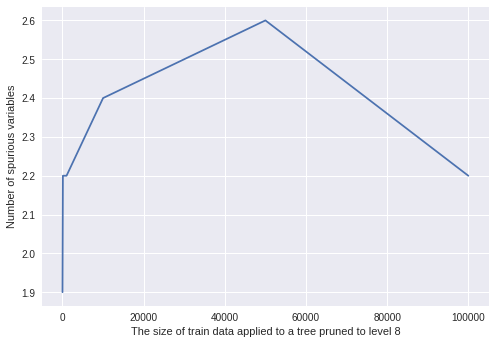

In [19]:
 
#dict_depth={0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.1, 5: 0.8, 6: 1.0, 7: 1.0, 8: 2.6, 9: 4.0, 10: 4.0, 11: 4.3, 12: 3.9, 13: 4.6, 14: 5.0, 15: 4.5, 16: 4.5, 17: 4.8}
dict_depth
import matplotlib.pylab as plt

lists = sorted(dict_depth.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("The size of train data applied to a tree pruned to level 8")
plt.ylabel("Number of spurious variables")
plt.show() 

In [1]:
dict_depth

NameError: ignored